<a href="https://colab.research.google.com/github/gaurav3014/Customer-Segmentation/blob/main/AI_mental_health_chatbot_using_LLM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install

In [ ]:
!pip install -q -U bitsandbytes
# !pip install -q -U git+https://github.com/huggingface/transformers.git
!pip install transformers==4.31 #temporary fix required owing to breaking changes on Aug 9th 2023
!pip install -q -U git+https://github.com/huggingface/peft.git
!pip install -q -U git+https://github.com/huggingface/accelerate.git
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.15.1
    Uninstalling tokenizers-0.15.1:
      Successfully uninstalled tokenizers-0.15.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 270.9/270.9 kB 2.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 

In [ ]:
# Required when training models/data that are gated on HuggingFace, and required for pushing models to HuggingFace
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

Load the model to use: Llama-7B!

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig

model_id = "meta-llama/Llama-2-7b-chat-hf" ## "Trelis/Llama-2-7b-chat-hf-sharded-bf16" is an alternative if you don't have access via Meta on HuggingFace
# model_id = "meta-llama/Llama-2-13b-chat-hf"
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, quantization_config=bnb_config, device_map={"":0})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

# Training Setup

Then we have to apply some preprocessing to the model to prepare it for training. For that use the `prepare_model_for_kbit_training` method from PEFT.

In [ ]:
from peft import prepare_model_for_kbit_training

model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [ ]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}"
    )

In [ ]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=8,
    lora_alpha=32,
    # target_modules=["query_key_value"],
    target_modules=["self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.o_proj"], #specific to Llama models.
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 8388608 || all params: 3508801536 || trainable%: 0.23907331075678143


# Data Setup

Load a common dataset, english quotes, to fine tune our model on famous quotes.

In [ ]:
from datasets import load_dataset

data = load_dataset("jsfactory/mental_health_reddit_posts")
data = data.map(lambda samples: tokenizer(samples["body"]), batched=True)

Generating train split: 0 examples [00:00, ? examples/s]

Map:   0%|          | 0/24000 [00:00<?, ? examples/s]

# Training

Run the cell below to run the training! For the sake of the demo, we just ran it for few steps just to showcase how to use this integration with existing tools on the HF ecosystem.

In [ ]:
import transformers

# needed for Llama tokenizer
tokenizer.pad_token = tokenizer.eos_token # </s>
 #Configures the training process using the Transformers Trainer class, specifying parameters like batch size,
 #optimization strategy, and output directory
trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=1,
        gradient_accumulation_steps=4,
        warmup_steps=2,
        max_steps=10,
        learning_rate=2e-4,
        fp16=True,
        logging_steps=1,
        output_dir="outputs",
        optim="paged_adamw_8bit"
    ),
    data_collator=transformers.DataCollatorForLanguageModeling(tokenizer, mlm=False),
)
model.config.use_cache = False  # silence the warnings. Please re-enable for inference!
trainer.train()

You're using a LlamaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:429: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.
  warnings.warn(


Step,Training Loss
1,3.536500
2,3.668000
3,3.515600
4,3.508700
5,3.792900
6,3.289500
7,2.927800
8,3.176200
9,3.043100
10,3.190500


TrainOutput(global_step=10, training_loss=3.3648791551589965, metrics={'train_runtime': 55.7248, 'train_samples_per_second': 0.718, 'train_steps_per_second': 0.179, 'total_flos': 58346900004864.0, 'train_loss': 3.3648791551589965, 'epoch': 0.0})

# Inference

In [ ]:
from transformers import TextStreamer
model.config.use_cache = True
model.eval()
#Sets up the TextStreamer for generating text based on user prompts. The model is put in evaluation mode.

PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): LlamaForCausalLM(
      (model): LlamaModel(
        (embed_tokens): Embedding(32000, 4096, padding_idx=0)
        (layers): ModuleList(
          (0-31): 32 x LlamaDecoderLayer(
            (self_attn): LlamaAttention(
              (q_proj): lora.Linear4bit(
                (base_layer): Linear4bit(in_features=4096, out_features=4096, bias=False)
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.05, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=4096, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=4096, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict()
              )
              (k_proj): lora.Linear4bit(
                (base_layer)

In [ ]:
# Define a stream *without* function calling capabilities
def stream(user_prompt):
    runtimeFlag = "cuda:0"
    system_prompt = 'You are a helpful assistant that provides accurate and concise responses'

    B_INST, E_INST = "[INST]", "[/INST]"
    B_SYS, E_SYS = "<<SYS>>\n", "\n<</SYS>>\n\n"

    prompt = f"{B_INST} {B_SYS}{system_prompt.strip()}{E_SYS}{user_prompt.strip()} {E_INST}\n\n"

    inputs = tokenizer([prompt], return_tensors="pt").to(runtimeFlag)

    streamer = TextStreamer(tokenizer)

    # Despite returning the usual output, the streamer will also print the generated text to stdout.
    _ = model.generate(**inputs, streamer=streamer, max_new_tokens=500)

In [ ]:
#stream(input(""))
def chat_with_bot():
    while True:
        user_input = input(" ")

        # You can replace the next line with your chatbot logic
        bot_response = stream(user_input)

        print(bot_response)

        if user_input.lower() == "exit":
            print("thank you if you aynthing ask me. Goodbye! have a nice day")
            break

if __name__ == "__main__":
    chat_with_bot()


 i feeling lonly
<s> [INST] <<SYS>>
You are a helpful assistant that provides accurate and concise responses
<</SYS>>

i feeling lonly [/INST]

Sorry to hear that you're feeling lonely. It can be challenging to feel disconnected from others and lack social interaction. Here are some suggestions that may help:

1. Reach out to friends and family: Talking to loved ones can help alleviate feelings of loneliness. Even a quick phone call or text can make you feel more connected.
2. Join a social group or club: Find a group that aligns with your interests, such as a book club, sports team, or volunteer organization. This can provide opportunities to meet new people and build friendships.
3. Try online communities: Join online forums or social media groups centered around a hobby or interest. This can help you connect with like-minded individuals and feel less lonely.
4. Take a class or workshop: Learning a new skill or hobby can be a great way to meet others who share your interests.
5. Prac

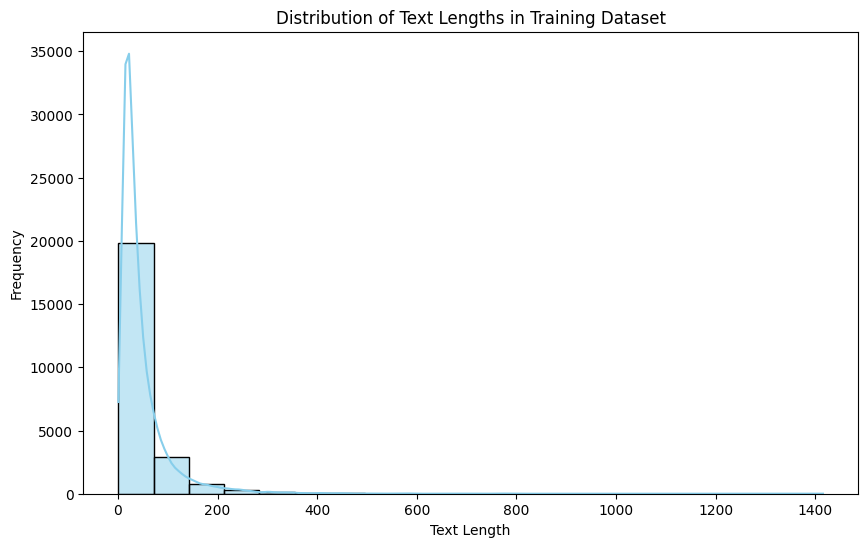

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# EDA: Distribution of Text Lengths in the Dataset
lengths = [len(sample.split()) for sample in data["train"]["body"]]

plt.figure(figsize=(10, 6))
sns.histplot(lengths, bins=20, kde=True, color='skyblue')
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.title("Distribution of Text Lengths in Training Dataset")
plt.show()


In [ ]:
print(trainer.state.log_history)


[{'loss': 3.5365, 'learning_rate': 0.0001, 'epoch': 0.0, 'step': 1}, {'loss': 3.668, 'learning_rate': 0.0002, 'epoch': 0.0, 'step': 2}, {'loss': 3.5169, 'learning_rate': 0.000175, 'epoch': 0.0, 'step': 3}, {'loss': 3.5107, 'learning_rate': 0.00015000000000000001, 'epoch': 0.0, 'step': 4}, {'loss': 3.7981, 'learning_rate': 0.000125, 'epoch': 0.0, 'step': 5}, {'loss': 3.2945, 'learning_rate': 0.0001, 'epoch': 0.0, 'step': 6}, {'loss': 2.9316, 'learning_rate': 7.500000000000001e-05, 'epoch': 0.0, 'step': 7}, {'loss': 3.1781, 'learning_rate': 5e-05, 'epoch': 0.0, 'step': 8}, {'loss': 3.0438, 'learning_rate': 2.5e-05, 'epoch': 0.0, 'step': 9}, {'loss': 3.1935, 'learning_rate': 0.0, 'epoch': 0.0, 'step': 10}, {'train_runtime': 59.7319, 'train_samples_per_second': 0.67, 'train_steps_per_second': 0.167, 'total_flos': 58346900004864.0, 'train_loss': 3.3671673774719237, 'epoch': 0.0, 'step': 10}]


# Push Model to Hub

In [ ]:
# Extract the last portion of the base_model
base_model_name = model_id.split("/")[-1]

# Define the save and push paths
adapter_model = f"Trelis/{base_model_name}-fine-tuned-adapters"  #adjust 'Trelis' to your HuggingFace organisation
new_model = f"Trelis/{base_model_name}-fine-tuned" #adjust 'Trelis' to your HuggingFace organisation

In [ ]:
# Save the model
model.save_pretrained(adapter_model, push_to_hub=True, use_auth_token=True)

# Push the model to the hub
model.push_to_hub(adapter_model, use_auth_token=True)

In [ ]:
# reload the base model (you might need a pro subscription for this because you may need a high RAM environment for the 13B model since this is loading the full original model, not quantized)
model = AutoModelForCausalLM.from_pretrained(model_id, device_map='cpu', trust_remote_code=True, torch_dtype=torch.float16, cache_dir=cache_dir)

In [ ]:
from peft import PeftModel

# load perf model with new adapters
model = PeftModel.from_pretrained(
    model,
    adapter_model,
)

In [ ]:
model = model.merge_and_unload() # merge adapters with the base model.

In [ ]:
model.push_to_hub(new_model, use_auth_token=True, max_shard_size="5GB")

In [ ]:
#Push the tokenizer
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.push_to_hub(new_model, use_auth_token=True)